# 🎯 **Goals of the Notebook**  

This notebook aims to **reproduce the results** of the paper  
📖 *Explainable AI for Trees: From Local Explanations to Global Understanding* by **S.L. Lundberg et al. (2019)**.  

It leverages some code from [this repository](https://github.com/suinleelab/treeexplainer-study) and focuses **exclusively** on the **NHANES I dataset**, which is one of the three datasets used in the original study.  

---

## **Outline**  

🔹 **1. Data Loading** – Load the dataset following the original approach.  
🔹 **2. Problem Exploration** – Understand key features and distributions.  
🔹 **3. Model Training** – Train:  
   - 🌳 an **XGBoost model**  
   - 📉 a **linear model**  
   *(Hyperparameter tuning via **RandomSearch**)*
   
🔹 **4. Algorithm Implementation** – Code Algorithm 1 (Explainer) **from scratch**.  
🔹 **5. SHAP Comparison** – Compare our implementation with `TreeExplainer` from the **SHAP** library.  
🔹 **6. Complexity Analysis** – Evaluate **computational efficiency**.  
🔹 **7. Dependence Plots** – Analyze **feature dependencies & interactions**.  
🔹 **8. Global vs. Local SHAP** – Compare **SHAP values** with the **Gain method**.  

---

**G. Vindry & C. Pernot**


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import xgboost as xgb
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import sklearn
from tqdm import tqdm
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             average_precision_score, precision_recall_curve, roc_curve)
from sklearn.linear_model import LogisticRegression
import time


In [3]:
import os 
print(os.getcwd())
os.chdir("./TreeShap/notebooks/mortality")
print(os.getcwd())

/Users/Corentin/Desktop/MVA 2024-2025/S2/Protein
/Users/Corentin/Desktop/MVA 2024-2025/S2/Protein/TreeShap/notebooks/mortality


## **Load data according to their methodology**

In [4]:
import loadnhanes

In [5]:
X,y = loadnhanes._load()

# clean up a bit
for c in X.columns:
    if c.endswith("_isBlank"):
        del X[c]   
X["bmi"] = 10000 * X["weight"].values.copy() / (X["height"].values.copy() * X["height"].values.copy())
del X["weight"]
del X["height"]
del X["urine_hematest_isTrace"] # would have no variance in the strain set
del X["SGOT_isBlankbutapplicable"] # would have no variance in the strain set
del X["calcium_isBlankbutapplicable"] # would have no variance in the strain set
del X["uric_acid_isBlankbutapplicable"] # would only have one true value in the train set
del X["urine_hematest_isVerylarge"] # would only have one true value in the train set
del X["total_bilirubin_isBlankbutapplicable"] # would only have one true value in the train set
del X["alkaline_phosphatase_isBlankbutapplicable"] # would only have one true value in the train set
del X["hemoglobin_isUnacceptable"] # redundant with hematocrit_isUnacceptable
rows = np.where(np.invert(np.isnan(X["systolic_blood_pressure"]) | np.isnan(X["bmi"])))[0]
X = X.iloc[rows,:]
y = y[rows]
y_binary = 1- (y < 0).astype(int) ### 0 : still alive, 1: died

name_map = {
    "sex_isFemale": "Sex",
    "age": "Age",
    "systolic_blood_pressure": "Systolic blood pressure",
    "bmi": "BMI",
    "white_blood_cells": "White blood cells", # (mg/dL)
    "sedimentation_rate": "Sedimentation rate",
    "serum_albumin": "Blood albumin",
    "alkaline_phosphatase": "Alkaline phosphatase",
    "cholesterol": "Total cholesterol",
    "physical_activity": "Physical activity",
    "hematocrit": "Hematocrit",
    "uric_acid": "Uric acid",
    "red_blood_cells": "Red blood cells",
    "urine_albumin_isNegative": "Albumin present in urine",
    "serum_protein": "Blood protein"
}
mapped_feature_names = list(map(lambda x: name_map.get(x, x), X.columns))

# split by patient id
pids = np.unique(X.index.values)
train_pids,test_pids = train_test_split(pids, random_state=0)
strain_pids,valid_pids = train_test_split(train_pids, random_state=0)

# find the indexes of the samples from the patient ids
train_inds = np.where([p in train_pids for p in X.index.values])[0]
strain_inds = np.where([p in strain_pids for p in X.index.values])[0]
valid_inds = np.where([p in valid_pids for p in X.index.values])[0]
test_inds = np.where([p in test_pids for p in X.index.values])[0]

# create the split datasets
X_train = X.iloc[train_inds,:]
X_strain = X.iloc[strain_inds,:]
X_valid = X.iloc[valid_inds,:]
X_test = X.iloc[test_inds,:]
y_train = y_binary[train_inds]
y_strain = y_binary[strain_inds]
y_valid = y_binary[valid_inds]
y_test = y_binary[test_inds]

# mean impute for linear and deep models
imp = SimpleImputer()
imp.fit(X_strain)
X_strain_imp = imp.transform(X_strain)
X_train_imp = imp.transform(X_train)
X_valid_imp = imp.transform(X_valid)
X_test_imp = imp.transform(X_test)
X_imp = imp.transform(X)

# standardize
scaler = StandardScaler()
scaler.fit(X_strain_imp)
X_strain_imp = scaler.transform(X_strain_imp)
X_train_imp = scaler.transform(X_train_imp)
X_valid_imp = scaler.transform(X_valid_imp)
X_test_imp = scaler.transform(X_test_imp)
X_imp = scaler.transform(X_imp)

number of people surviving  9622
number of people not surviving  4785


In [6]:
X.shape

(14264, 79)

(array([7725., 1614.,  195.,   19.,    0.,  725.,  950., 1141., 1204.,
         691.]),
 array([-22.08333333, -17.73333333, -13.38333333,  -9.03333333,
         -4.68333333,  -0.33333333,   4.01666667,   8.36666667,
         12.71666667,  17.06666667,  21.41666667]),
 <BarContainer object of 10 artists>)

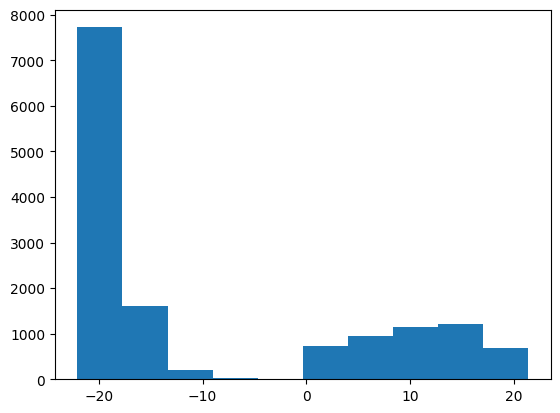

In [7]:
plt.hist(y)

> If y > 0 → The participant died within 15 years after the NHANES I examination. \
> If y < 0 → The participant was still alive 15 years after their examination. \
> If y is NaN → The survival time is unknown (such participants are removed from the dataset).

#### **Usage**
This dataset can be used for:

- Binary classification (someone survived 15+ years or not?).
- Survival analysis (modeling the time until death using y as the event time).


#### **In their study they decided to model this problem as a Cox Proportional Hazards but we can choose to model it as a classification problem**

In [8]:
y_binary = 1- (y < 0).astype(int) ### 0 : still alive, 1: died
y_binary

array([0, 0, 0, ..., 0, 0, 0])

## **Check the performances on this dataset**

### **Train XGBoost**

In [9]:
## parameter distributions for random search
param_dist = {
    "learning_rate": np.logspace(-4, -1, 10),
    "n_estimators": np.arange(100, 500, 200),
    "max_depth": np.arange(2, 10),
    "subsample": np.linspace(0.4, 1.0, 7),
    "reg_lambda": np.linspace(0, 10, 6),
    "reg_alpha": np.linspace(0, 5, 6),
    "colsample_bytree": np.linspace(0.5, 1.0, 6)
}

## init XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state=42)

## random search
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=30,
                                   scoring='roc_auc', cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_strain, y_strain)

## best params for random search
best_params = random_search.best_params_
print("Best parameters from random search:", best_params)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=4.0, reg_lambda=10.0, subsample=0.4; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=4.0, reg_lambda=10.0, subsample=0.4; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=4.0, reg_lambda=10.0, subsample=0.4; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.0001, max_depth=3, n_estimators=300, reg_alpha=5.0, reg_lambda=8.0, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.0001, max_depth=3, n_estimators=300, reg_alpha=5.0, reg_lambda=8.0, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.0001, max_depth=3, n_estimators=300, reg_alpha=5.0, reg_lambda=8.0, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.0

[0]	validation_0-logloss:0.61018
[299]	validation_0-logloss:0.39905
Confusion Matrix:
 [[1630  192]
 [ 253  600]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      1822
           1       0.76      0.70      0.73       853

    accuracy                           0.83      2675
   macro avg       0.81      0.80      0.80      2675
weighted avg       0.83      0.83      0.83      2675

ROC AUC Score: 0.8746
PR AUC Score: 0.7824


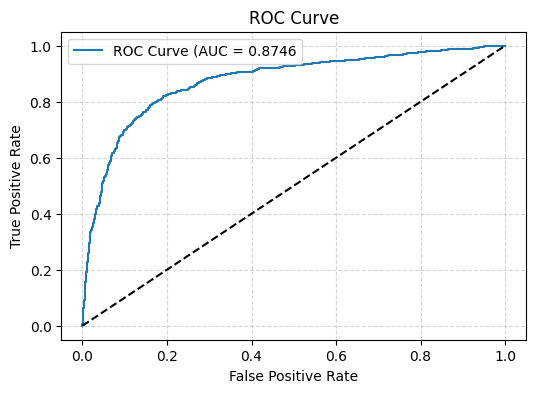

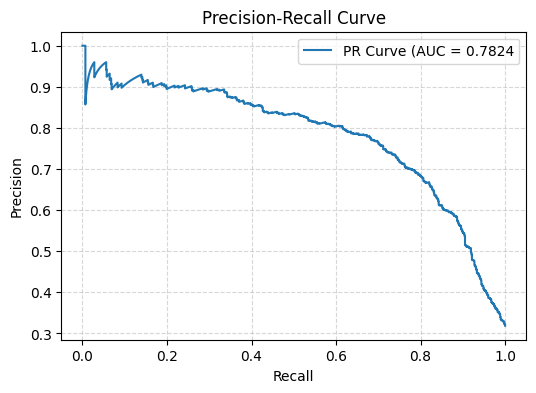

In [158]:
best_params= {'subsample': 0.5, 'reg_lambda': 8.0, 'reg_alpha': 5.0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.046415888336127774, 'colsample_bytree': 0.9}

## Final model 
final_xgb = xgb.XGBClassifier(**best_params, objective='binary:logistic', n_jobs=-1, random_state=42)
final_xgb.fit(
    X_strain, y_strain, verbose=500,
    eval_set=[(X_valid, y_valid)])

y_pred = final_xgb.predict(X_valid)
y_pred_proba = final_xgb.predict_proba(X_valid)[:, 1]

## Metrics
conf_matrix = confusion_matrix(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred_proba)
pr_auc = average_precision_score(y_valid, y_pred_proba)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_valid, y_pred))
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"PR AUC Score: {pr_auc:.4f}")

## ROC Curve
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(alpha=0.5, linestyle='--')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_valid, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(alpha=0.5, linestyle='--')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

### **Train Linear Model**

In [12]:
## Defining parameter distributions for random search for logistic regression
param_dist_logistic = {
    "penalty": ["l1", "l2", "elasticnet"],
    "C": np.logspace(-4, 4, 10),
    "solver": ["saga"],  # `saga` supports all penalty types
    "l1_ratio": np.linspace(0, 1, 10)  # Only used for elasticnet
}

## init Logistic Regression model
logistic_model = LogisticRegression(max_iter=10000, random_state=42, solver='saga', penalty='elasticnet')

## Perform random search
random_search_logistic = RandomizedSearchCV(logistic_model, param_distributions=param_dist_logistic, n_iter=30,
                                            scoring='roc_auc', cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search_logistic.fit(X_strain_imp, y_strain)

## Best params from random search
best_params_logistic = random_search_logistic.best_params_
print("Best parameters from random search for logistic regression:", best_params_logistic)


Confusion Matrix:
 [[1612  210]
 [ 254  599]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87      1822
           1       0.74      0.70      0.72       853

    accuracy                           0.83      2675
   macro avg       0.80      0.79      0.80      2675
weighted avg       0.82      0.83      0.83      2675

ROC AUC Score: 0.8730
PR AUC Score: 0.7802


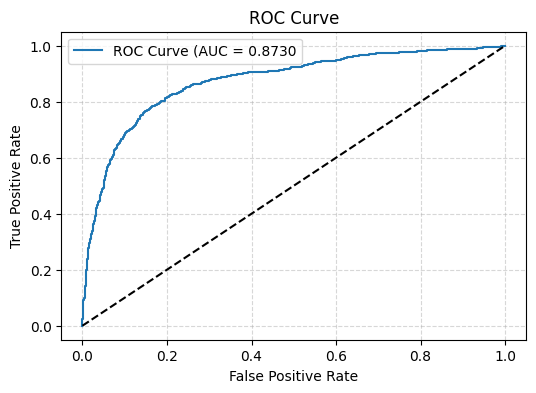

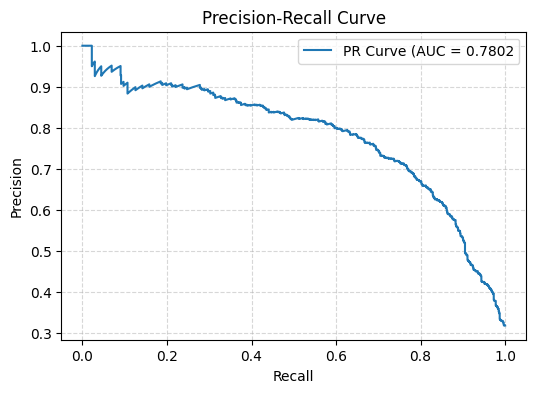

In [13]:
best_params_logistic = {'solver': 'saga',
               'penalty': 'elasticnet', 
               'l1_ratio': 0.7777777777777777, 
               'C': 0.046415888336127774}

final_logistic = LogisticRegression(**best_params_logistic, max_iter=10000, random_state=42)
final_logistic.fit(X_strain_imp, y_strain)

y_pred = final_logistic.predict(X_valid_imp)
y_pred_proba = final_logistic.predict_proba(X_valid_imp)[:, 1]

conf_matrix = confusion_matrix(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred_proba)
pr_auc = average_precision_score(y_valid, y_pred_proba)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_valid, y_pred))
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"PR AUC Score: {pr_auc:.4f}")

## Plots
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(alpha=0.5, linestyle='--')
plt.title('ROC Curve')
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_valid, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(alpha=0.5, linestyle='--')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# **TreeExplainer**
### **1) Bruteforce : Algorithm 1**

In [231]:
print(os.getcwd())
os.chdir("../..")
print(os.getcwd())

/Users/Corentin/Desktop/MVA 2024-2025/S2/Protein/TreeShap/notebooks/mortality
/Users/Corentin/Desktop/MVA 2024-2025/S2/Protein/TreeShap


In [316]:
import bruteforce_treeshap
import importlib
importlib.reload(bruteforce_treeshap)

from bruteforce_treeshap import compute_shap_for_dataset

In [233]:
### specific example 
S_name = ["age","bmi"] 
S = set(X_train.columns.get_indexer(S_name))

shap_values = compute_shap_for_dataset(final_xgb, X_train, S, precise_samples=[1])
print(f"Shap values for {S_name[0]} for positive patient (those who died)")
print(shap_values) 
print("__________________")
shap_values = compute_shap_for_dataset(final_xgb, X_train, S, precise_samples=[5])
print(f"Shap values for {S_name[0]} for negative patient (those who survived)")
print(shap_values) 

100%|██████████| 1/1 [00:05<00:00,  5.57s/it]


Shap values for age for positive patient (those who died)
[{'age': -0.8793099228878363, 'bmi': -0.12392374533240377}]
__________________


100%|██████████| 1/1 [00:05<00:00,  5.55s/it]

Shap values for age for negative patient (those who survived)
[{'age': 0.41325906619082886, 'bmi': -0.14120997420816753}]


In [234]:
indices_1 = np.where(y_binary[:50] == 1)[0]
indices_0 = np.where(y_binary[:50] == 0)[0]

In [235]:
S_name = ["age","bmi"] 
S = set(X_train.columns.get_indexer(S_name))

shap_values = compute_shap_for_dataset(final_xgb, X, S, precise_samples=indices_1)
print(f"Shap values for {S_name[0]} for positive patients (those who died)")
print(shap_values) 
print("__________________")
shap_values = compute_shap_for_dataset(final_xgb, X, S, precise_samples=indices_0)
print(f"Shap values for {S_name[0]} for negative patients (those who survived)")
print(shap_values) 

100%|██████████| 9/9 [00:46<00:00,  5.20s/it]


Shap values for age for positive patients (those who died)
[{'age': -0.42109926508610906, 'bmi': -0.02310167534847534}
 {'age': -1.1378667665885647, 'bmi': -0.0031989758516372565}
 {'age': -0.4249523950640592, 'bmi': -0.16866164865073344}
 {'age': 0.6178384033508664, 'bmi': -0.04273978519800636}
 {'age': 0.38110541694403716, 'bmi': 0.10669832729948531}
 {'age': -0.07531596269666174, 'bmi': -0.026756058133114522}
 {'age': 1.576128848239258, 'bmi': 0.2912416589180157}
 {'age': -1.2808170174153615, 'bmi': 0.04628043468443568}
 {'age': -0.8869763280023445, 'bmi': -0.1367791556431034}]
__________________


100%|██████████| 41/41 [04:28<00:00,  6.54s/it]

Shap values for age for negative patients (those who survived)
[{'age': -0.4041282607643574, 'bmi': -0.1299802568768495}
 {'age': -0.8793099228878363, 'bmi': -0.12392374533240377}
 {'age': -1.1964316711065637, 'bmi': -0.11889959565484955}
 {'age': -0.5950703758229721, 'bmi': -0.10365945953737707}
 {'age': -1.283577347839992, 'bmi': 0.24570666312043343}
 {'age': -1.0104856081320253, 'bmi': -0.10671892760569418}
 {'age': -0.5983095720404933, 'bmi': -0.023018524630432233}
 {'age': 0.41325906619082886, 'bmi': -0.14120997420816753}
 {'age': -1.2423478425636907, 'bmi': 0.25193750920554453}
 {'age': -1.1985038902416625, 'bmi': -0.1135345589292097}
 {'age': -1.211800551461236, 'bmi': -0.1060362498396918}
 {'age': -1.2435543019883846, 'bmi': 0.2531439686302383}
 {'age': -0.7247245297068834, 'bmi': -0.15580892338766167}
 {'age': -1.0464876060775519, 'bmi': -0.004611519753166106}
 {'age': -1.2524544594660485, 'bmi': 0.17987271429570334}
 {'age': -0.9740183512292759, 'bmi': -0.1363426222257199}
 {

### **Comparison with TreeExplainer implemented in the shap library**

In [320]:
## Features 
S_name = ["age", 'bmi']
S = set(X_train.columns.get_indexer(S_name))

In [322]:
## SHAP Algo Bruteforce
shap_values_custom = compute_shap_for_dataset(final_xgb, X_train[:10], S, nb_samples=None) 
shap_values_custom_selected = shap_values_custom
shap_values_custom_selected = pd.DataFrame(list(shap_values_custom_selected)).to_numpy()

## SHAP Tree Explainer
explainer = shap.TreeExplainer(final_xgb, feature_perturbation="tree_path_dependent")
shap_values_lib = explainer.shap_values(X_train.head(10),check_additivity=True)

## Results 
print("Custom")
print(shap_values_custom_selected)
#print("lib: (Rows sums should be difference btw prediction and dataset average)")
shap_values_lib_selected = shap_values_lib[:10, X_train.columns.get_indexer(S_name)]
# print(shap_values_lib.sum(axis=-1))
# print(f"{explainer.expected_value=}")
print("TreeSHAP")
print(shap_values_lib_selected)

100%|██████████| 10/10 [00:50<00:00,  5.04s/it]

Custom
[[-0.41299315 -0.13786824]
 [-0.81023825 -0.12261464]
 [-1.1936594  -0.11912282]
 [-1.27676617  0.24815175]
 [-1.00127321 -0.10834152]
 [ 0.55409895 -0.14909486]
 [-1.23888365  0.251799  ]
 [-1.19683184 -0.1133868 ]
 [-1.21180055 -0.10603625]
 [-1.24009011  0.25300546]]
[[-0.63159883 -0.19415312]
 [-1.2238818  -0.17267703]
 [-1.5545337  -0.15007445]
 [-1.5645958   0.32244727]
 [-1.392703   -0.18623538]
 [ 0.82805705 -0.1673315 ]
 [-1.7011788   0.26032463]
 [-2.0048838  -0.17813882]
 [-1.8021411  -0.09718329]
 [-1.5940112   0.24946737]]


In [288]:
## Compare results
diff = shap_values_lib_selected - shap_values_custom_selected

print(f"Differences between TreeExplainer SHAP and SHAP bruteforce:\n{diff}")

Differences between TreeExplainer SHAP and SHAP bruteforce:
[[-0.21860569 -0.05628487]
 [-0.41364359 -0.05006238]
 [-0.36087432 -0.03095164]
 [-0.28782965  0.07429552]
 [-0.39142984 -0.07789386]
 [ 0.2739581  -0.01823664]
 [-0.46229514  0.00852563]
 [-0.80805192 -0.06475202]
 [-0.59034052  0.00885296]
 [-0.35392108 -0.00353808]]


In [332]:
feature_subset_size = 10
feature_names = list(X_train.columns)


S_name = random.sample(feature_names, feature_subset_size)
S_indices = X_train.columns.get_indexer(S_name)

name_index_pairs = list(zip(S_name, S_indices))
sorted_pairs = sorted(name_index_pairs, key=lambda x: x[1])
S_name_sorted = [name for name, idx in sorted_pairs]
S_indices_sorted = [idx for name, idx in sorted_pairs]




[('BUN', 10), ('pulse_pressure', 77), ('SGOT', 7), ('urine_albumin_is>=1000', 54), ('urine_glucose_isBlankbutapplicable', 63), ('physical_activity', 2), ('urine_hematest_isBlankbutapplicable', 70), ('uric_acid_isUnacceptable', 74), ('sodium', 21), ('segmented_neutrophils', 42)]
['BUN', 'pulse_pressure', 'SGOT', 'urine_albumin_is>=1000', 'urine_glucose_isBlankbutapplicable', 'physical_activity', 'urine_hematest_isBlankbutapplicable', 'uric_acid_isUnacceptable', 'sodium', 'segmented_neutrophils']
[10 77  7 54 63  2 70 74 21 42]
['physical_activity', 'SGOT', 'BUN', 'sodium', 'segmented_neutrophils', 'urine_albumin_is>=1000', 'urine_glucose_isBlankbutapplicable', 'urine_hematest_isBlankbutapplicable', 'uric_acid_isUnacceptable', 'pulse_pressure']
[2, 7, 10, 21, 42, 54, 63, 70, 74, 77]


## **Run experiments to quantify the differences between values in Algo 1 and Algo 2**

In [323]:
from scipy.stats import ttest_rel, wilcoxon
import random

In [333]:
def evaluate_shap_difference(
    X, model, feature_names, sample_size=10, nb_trials=5,
    feature_subset_size=2, method="t-test"
):
    results = []

    for trial in range(nb_trials):
        S_name = random.sample(feature_names, feature_subset_size)

        S_indices = X.columns.get_indexer(S_name)
        name_index_pairs = list(zip(S_name, S_indices))
        sorted_pairs = sorted(name_index_pairs, key=lambda x: x[1])
        S_name_sorted = [name for name, idx in sorted_pairs]
        S_indices_sorted = [idx for name, idx in sorted_pairs]

        X_sample = X.sample(n=sample_size, random_state=trial)

        S_set = set(S_indices_sorted)
        shap_custom = compute_shap_for_dataset(model, X_sample, S_set)
        shap_custom = pd.DataFrame(list(shap_custom)).to_numpy()

        explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
        shap_tree = explainer.shap_values(X_sample, check_additivity=True)
        shap_tree = shap_tree[:, S_indices_sorted]

        for j, fname in enumerate(S_name_sorted):
            errors = shap_custom[:, j] - shap_tree[:, j]

            if method == "t-test":
                stat, pval = ttest_rel(shap_custom[:, j], shap_tree[:, j])
            elif method == "wilcoxon":
                stat, pval = wilcoxon(shap_custom[:, j], shap_tree[:, j])
            else:
                raise ValueError("Unknown method")

            results.append({
                "trial": trial,
                "feature": fname,
                "mean_error": errors.mean(),
                "std_error": errors.std(),
                "pval": pval,
                "method": method
            })

    return pd.DataFrame(results)


In [338]:
feature_names = ["sex_isFemale", "age","sodium","uric_acid","pulse_pressure","systolic_blood_pressure","bmi"]
evaluate_shap_difference(
    X_train, final_xgb, feature_names, sample_size=50, nb_trials=10,
    feature_subset_size=2, method="t-test"
)

100%|██████████| 50/50 [04:39<00:00,  5.60s/it]


,trial,feature,mean_error,std_error,pval,method
0,0,sodium,0.195944,0.102902,6.424423e-18,t-test
1,0,uric_acid,-0.057503,0.085902,2.251061e-05,t-test
2,1,sodium,-0.083598,0.070464,6.558217e-11,t-test
3,1,bmi,0.024086,0.060736,7.771720e-03,t-test
4,2,sodium,0.176610,0.117320,3.439009e-14,t-test
5,2,uric_acid,-0.075441,0.106676,9.168732e-06,t-test
6,3,sex_isFemale,0.077985,0.323887,9.826200e-02,t-test
7,3,uric_acid,0.154153,0.176105,1.488706e-07,t-test
8,4,uric_acid,0.205074,0.172280,5.953221e-11,t-test
9,4,systolic_blood_pressure,0.037121,0.054003,1.470438e-05,t-test


# **Time complexity** 
## **Time complexity of Bruteforce algorithm**

In [169]:
def time_bruteforce_per_tree(xgb_model, X_sample, max_features=70):
    """
    Mesure le temps d'exécution de l'algorithme brute-force en fonction du nombre de features.
    :param xgb_model: Modèle XGBoost entraîné
    :param X_sample: Échantillon de données (une seule instance)
    :param max_features: Nombre max de features à tester
    :return: Liste des temps d'exécution pour chaque M
    """
    times = []
    for M in range(1, max_features + 1,5):
        S = set(range(M))  # Prend les M premières features
        start_time = time.time()
        compute_shap_for_dataset(xgb_model, X_sample, S)
        end_time = time.time()
        times.append(end_time - start_time)
        print(f"M={M}, Time={times[-1]:.6f} sec")
    return times

In [170]:
M_max = 16  
X_sample = X_train.head(5)  # we set 10 samples

times = time_bruteforce_per_tree(final_xgb, X_sample, max_features=M_max)

100%|██████████| 5/5 [00:24<00:00,  4.94s/it]


M=1, Time=24.712780 sec


100%|██████████| 5/5 [00:41<00:00,  8.32s/it]


M=6, Time=41.585264 sec


100%|██████████| 5/5 [13:20<00:00, 160.09s/it]


M=11, Time=800.431554 sec


100%|██████████| 5/5 [8:43:47<00:00, 6285.47s/it]  

M=16, Time=31427.352709 sec


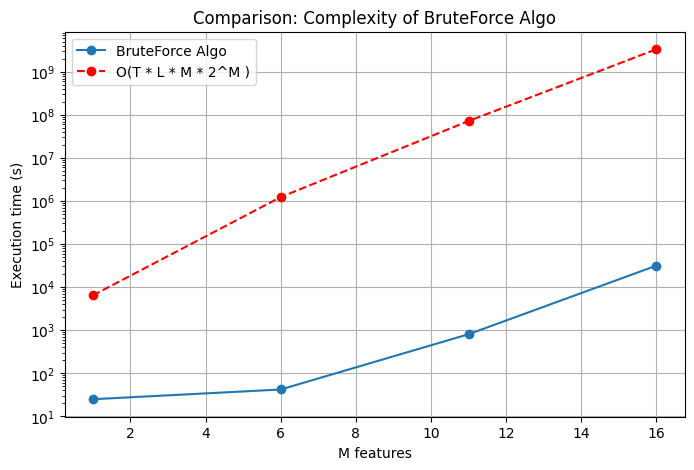

In [196]:
M = np.arange(1, M_max + 1,5)
T_fixed = 100 
L_fixed = 2**5  # nb leaves estimated wrt D (approx. L = 2^D)

## complexity : O(T * L * D^2)
theoretical_times = T_fixed * L_fixed * M * 2 ** M

## Plots
plt.figure(figsize=(8, 5))
plt.plot(M, list(times), marker="o", linestyle="-", label="BruteForce Algo")
plt.plot(M, theoretical_times, marker="o", linestyle="--", color="r", label="O(T * L * M * 2^M )")
plt.xlabel("M features")
plt.ylabel("Execution time (s)")
plt.yscale("log")  # Log-scale for quadratic growth visualization
plt.title("Comparison: Complexity of BruteForce Algo")
plt.legend()
plt.grid()
plt.show()

## **Time complexity Tree SHAP**

In [193]:
def measure_treeshap_runtime(X, y, max_depth_list, T=100):
    """
    Mesure le temps d'exécution de TreeExplainer en fonction de la profondeur des arbres (D),
    avec un nombre d'arbres fixe (T).
    
    :param X: Dataset (features)
    :param y: Labels
    :param max_depth_list: Liste des valeurs de D (profondeur des arbres)
    :param T: Nombre fixe d'arbres
    :return: Résultats sous forme de dictionnaire {D: temps d'exécution}
    """
    results = {}
    
    for D in max_depth_list:
        print(f"Test avec D={D}...")

        best_params["max_depth"] = D

        model = xgb.XGBClassifier(**best_params)
        model.fit(X, y)

        explainer = shap.TreeExplainer(model)

        ## Time complexity measurement 
        start_time = time.time()
        shap_values = explainer.shap_values(X, check_additivity=False) 
        end_time = time.time()

        elapsed_time = end_time - start_time
        results[D] = elapsed_time
        print(f"Temps d'exécution : {elapsed_time:.4f} sec")

    return results


In [194]:
## Params
max_depth_list = [2, 4, 6, 8, 10, 20, 30, 40, 70]  
T_fixed = 100 

X_sample = X_train.iloc[:10000] 
y_sample = y_train[:10000]

results = measure_treeshap_runtime(X_sample, y_sample, max_depth_list, T=T_fixed)

Test avec D=2...
Temps d'exécution : 0.2102 sec
Test avec D=4...
Temps d'exécution : 1.0029 sec
Test avec D=6...
Temps d'exécution : 3.4164 sec
Test avec D=8...
Temps d'exécution : 8.5500 sec
Test avec D=10...
Temps d'exécution : 13.7819 sec
Test avec D=20...
Temps d'exécution : 25.1577 sec
Test avec D=30...
Temps d'exécution : 30.1844 sec
Test avec D=40...
Temps d'exécution : 31.3400 sec
Test avec D=70...
Temps d'exécution : 28.3159 sec


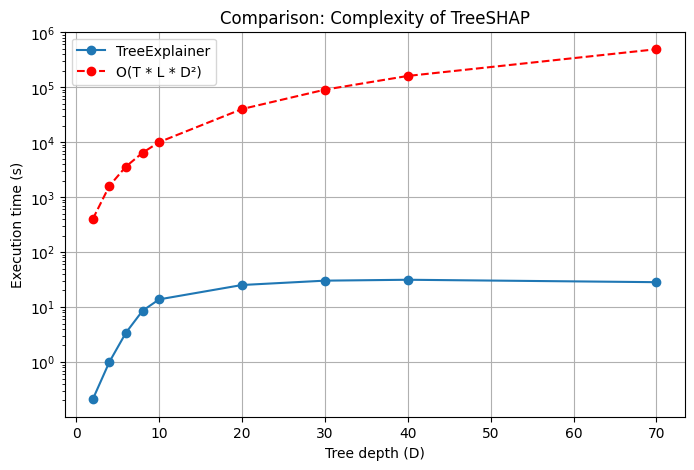

In [195]:
max_depth_list = np.array(max_depth_list)
T_fixed = 100 
L_fixed = np.array([2**x for x in max_depth_list]) # nb leaves estimated wrt D (approx. L = 2^D)
D_values = max_depth_list

## complexity : O(T * L * D^2)
theoretical_times = T_fixed * max_depth_list**2

## Plots
plt.figure(figsize=(8, 5))
plt.plot(max_depth_list, list(results.values()), marker="o", linestyle="-", label="TreeExplainer")
plt.plot(D_values, theoretical_times, marker="o", linestyle="--", color="r", label="O(T * L * D²)")
plt.xlabel("Tree depth (D)")
plt.ylabel("Execution time (s)")
plt.yscale("log")  # Log-scale for quadratic growth visualization
plt.title("Comparison: Complexity of TreeSHAP")
plt.legend()
plt.grid()
plt.show()


# **Dependence plots**

In [344]:
explainer = shap.TreeExplainer(final_xgb) 
shap_values_lib = explainer.shap_values(X)

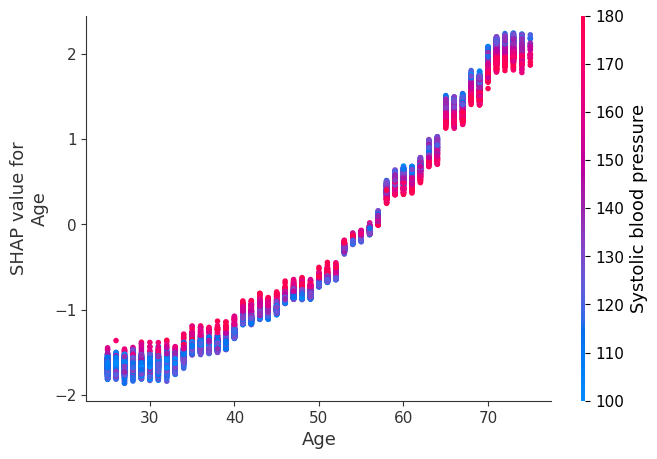

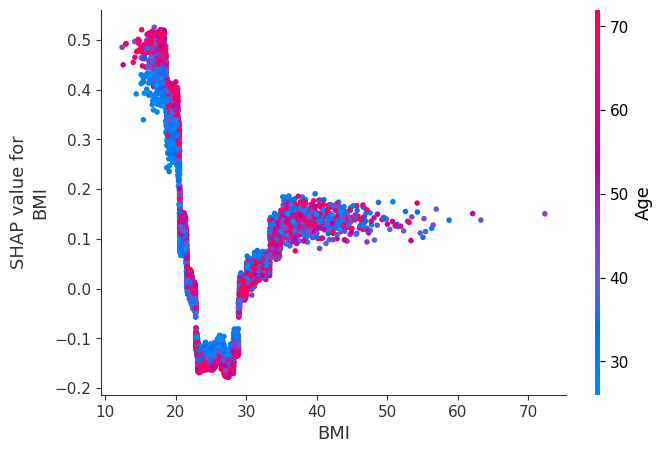

In [ ]:
shap.dependence_plot(("Age"), shap_values_lib, X,feature_names=np.array(mapped_feature_names))
shap.dependence_plot(("BMI"), shap_values_lib, X,feature_names=np.array(mapped_feature_names))

# **Interaction effects**

In [199]:
xgb_shap_interaction = shap.TreeExplainer(final_xgb).shap_interaction_values(X)

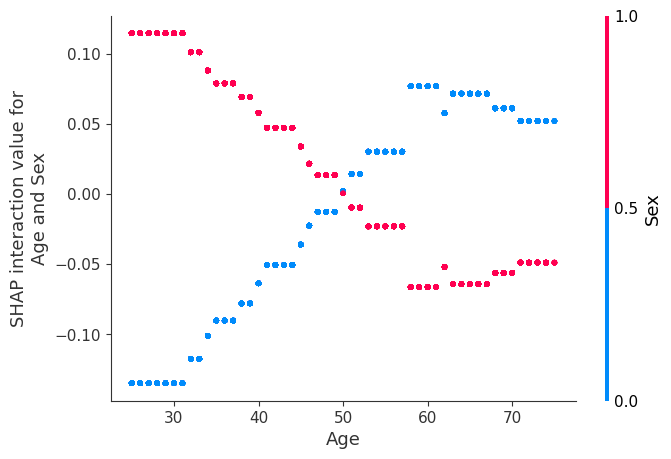

In [ ]:
shap.dependence_plot(("Age", "Sex"), xgb_shap_interaction, X, feature_names=np.array(mapped_feature_names), show=False)
plt.savefig("./figures/interactions_age_sex.png")
plt.show()

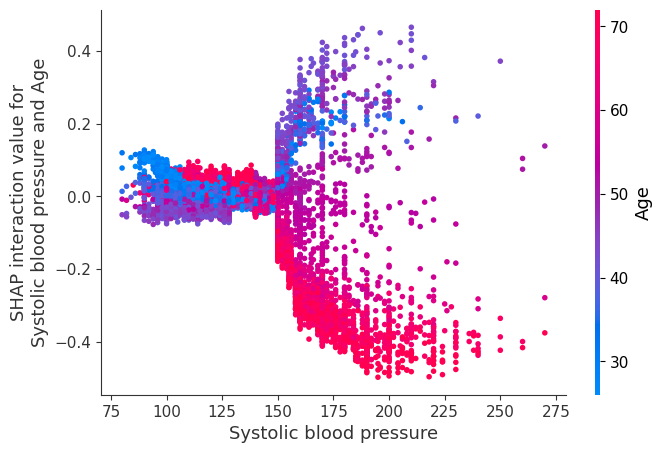

In [202]:
shap.dependence_plot(("Systolic blood pressure", "Age"), xgb_shap_interaction, X, feature_names=np.array(mapped_feature_names), show=False)
#plt.savefig("./figures/interactions_age_alkaline.png")
plt.show()

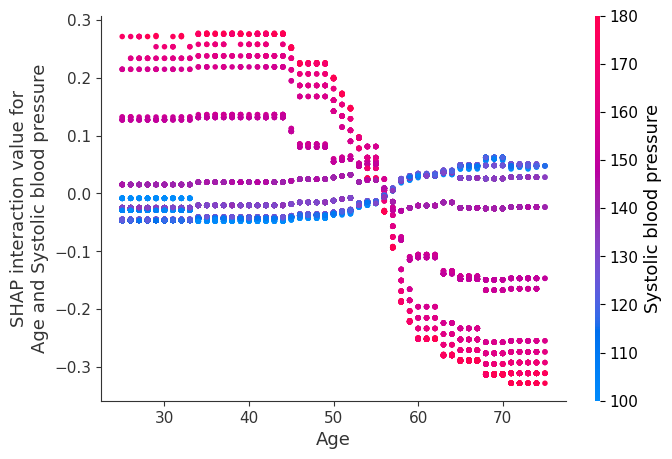

In [ ]:
shap.dependence_plot(("Age", "Systolic blood pressure"), xgb_shap_interaction, X, feature_names=np.array(mapped_feature_names), show=False)
plt.savefig("./figures/interactions_age_sbp.png")
plt.show()

## **Decomposition of the impact of a feature into interaction effects and main effect.**
### **Age and Systolic Blood Pressure**

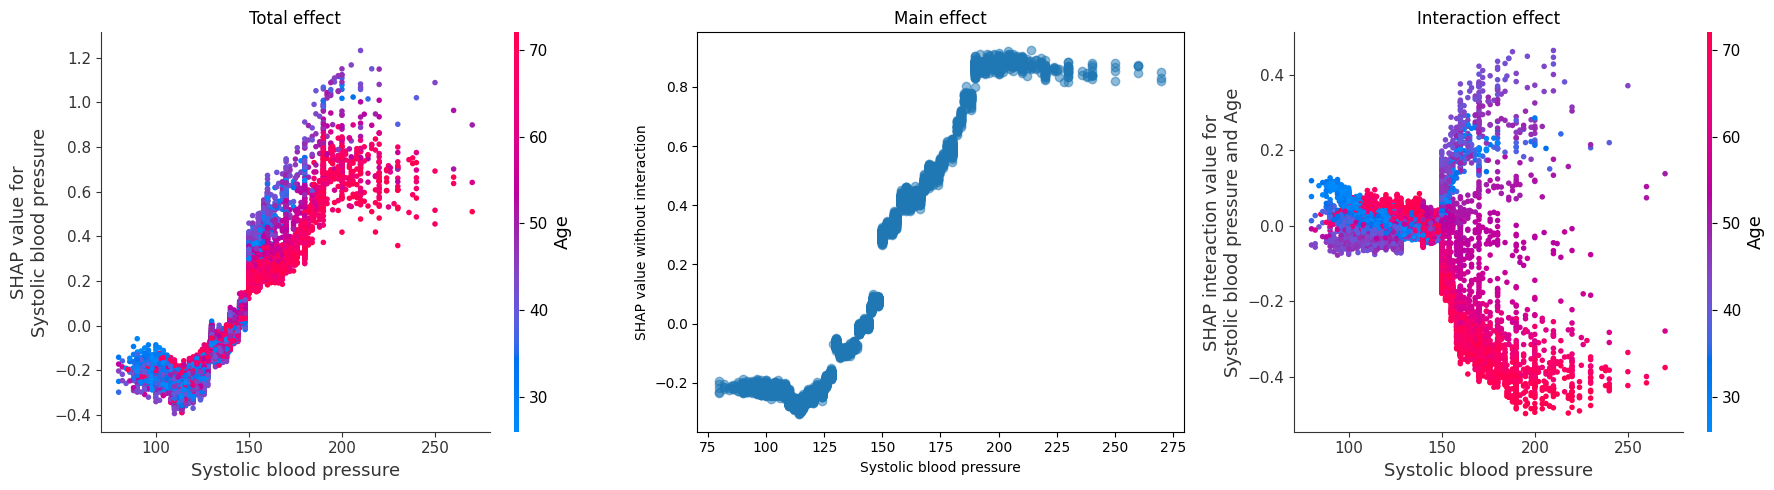

In [224]:
feature_names = np.array(mapped_feature_names)
i = np.where(feature_names == "Systolic blood pressure")[0][0]
j = np.where(feature_names == "Age")[0][0]

## Effects
main_effect = xgb_shap_interaction[:, i, i]
interaction_effect = xgb_shap_interaction[:, i, j]
residual = main_effect  # same as fig 4c

## Plots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

## fig 4b : classical SHAP
shap.dependence_plot(
    "Systolic blood pressure", 
    shap_values_lib, 
    X, 
    feature_names=feature_names, 
    interaction_index="Age", 
    ax=axs[0], 
    show=False
)
axs[0].set_title("Total effect")

## fig 4c : main effect without interaction
axs[1].scatter(X["systolic_blood_pressure"], residual, alpha=0.5)
axs[1].set_xlabel("Systolic blood pressure")
axs[1].set_ylabel("SHAP value without interaction")
axs[1].set_title("Main effect")

## fig 4d : interaction only
shap.dependence_plot(
    ("Systolic blood pressure", "Age"), 
    xgb_shap_interaction, 
    X, 
    feature_names=feature_names, 
    ax=axs[2], 
    show=False
)
axs[2].set_title("Interaction effect")

plt.tight_layout()
plt.show()

# **From Local to Global**

In [339]:
print(os.getcwd())
os.chdir("./notebooks/mortality")
print(os.getcwd())

/Users/Corentin/Desktop/MVA 2024-2025/S2/Protein/TreeShap
/Users/Corentin/Desktop/MVA 2024-2025/S2/Protein/TreeShap/notebooks/mortality


In [345]:
## Compute feature importance with gain method
xgb_feature_importance = final_xgb.get_booster().get_score(importance_type="gain")
sorted_importance = sorted(xgb_feature_importance.items(), key=lambda x: x[1], reverse=True)

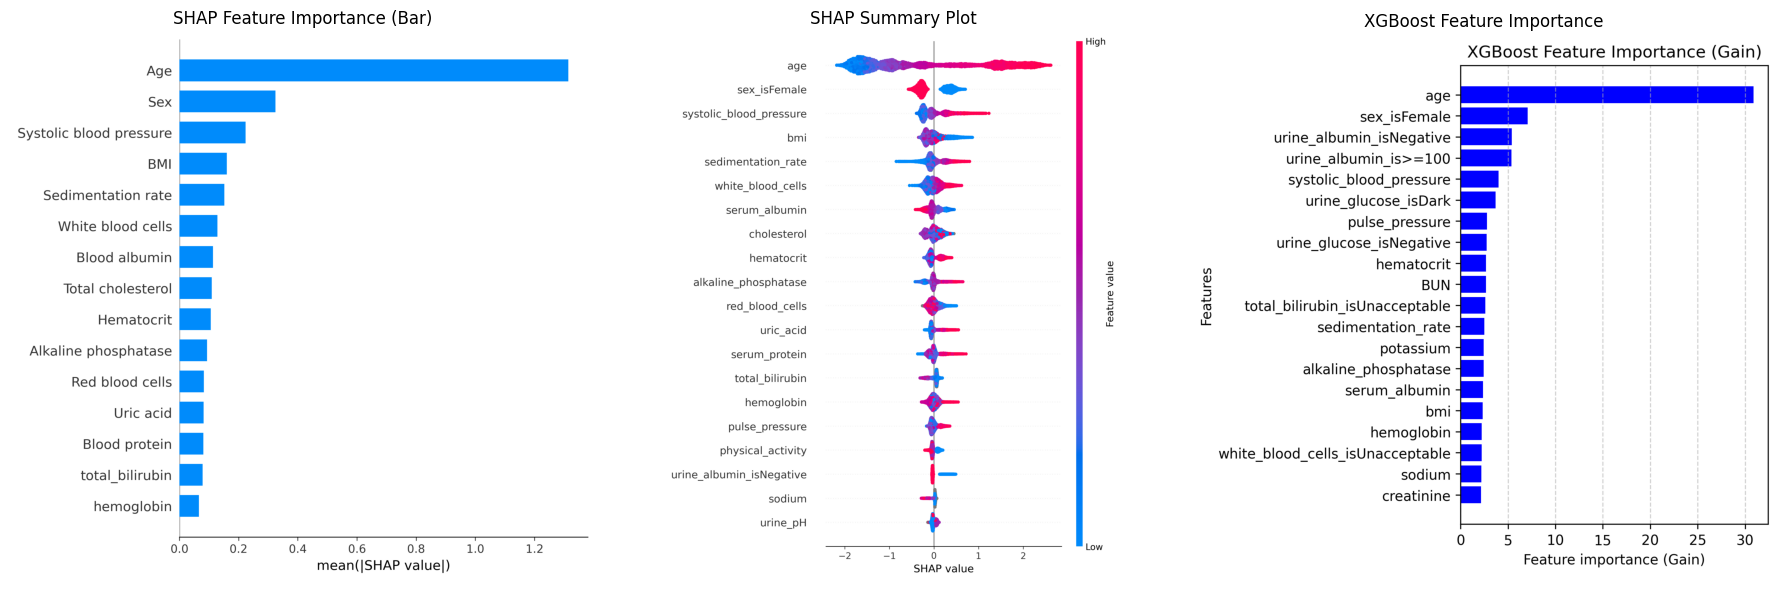

In [348]:

## Store figures 
shap_bar_plot_path = "./figures/shap_bar_plot.png"
shap_summary_plot_path = "./figures/shap_summary_plot.png"
xgb_importance_plot_path = "./figures/xgb_importance_plot.png"

## SHAP summary plot (bar)
plt.figure(figsize=(4, 6))
shap.summary_plot(
    shap_values_lib, X, feature_names=mapped_feature_names, plot_type="bar",
    max_display=15, show=False
)
plt.xlabel("mean(|SHAP value|)")
plt.savefig(shap_bar_plot_path, bbox_inches='tight', dpi=300)
plt.close()

## SHAP summary plot (beeswarm)
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values_lib, X, show=False)
plt.xlabel("SHAP value")
plt.savefig(shap_summary_plot_path, bbox_inches='tight', dpi=300)
plt.close()

## XGBoost Feature Importance plot
plt.figure(figsize=(4, 6))
plt.barh([x[0] for x in sorted_importance[:20]], [x[1] for x in sorted_importance[:20]], color="blue")
plt.xlabel("Feature importance (Gain)")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance (Gain)")
plt.gca().invert_yaxis()  # Mettre la feature la plus importante en haut
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.savefig(xgb_importance_plot_path, bbox_inches='tight', dpi=300)
plt.close()

## Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

shap_bar_img = plt.imread(shap_bar_plot_path)
shap_summary_img = plt.imread(shap_summary_plot_path)
xgb_importance_img = plt.imread(xgb_importance_plot_path)

axes[0].imshow(shap_bar_img)
axes[0].axis("off")
axes[0].set_title("SHAP Feature Importance (Bar)")

axes[1].imshow(shap_summary_img)
axes[1].axis("off")
axes[1].set_title("SHAP Summary Plot")

axes[2].imshow(xgb_importance_img)
axes[2].axis("off")
axes[2].set_title("XGBoost Feature Importance")

plt.tight_layout()
plt.show()
